# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 4: West-Nile-Virus-Prediction

### Feature Engineering for West Nile

Imports and setting date column to index


In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas_profiling as pdpro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import ensemble, preprocessing
%matplotlib inline

#### Load dataset 

In [2]:
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
spray = pd.read_csv('../assets/spray.csv')

In [3]:
#Change the headers to lowercase 
train.columns = map(str.lower, train.columns)
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent'],
      dtype='object')

In [4]:
test.columns = map(str.lower, test.columns)

In [5]:
spray.columns = map(str.lower, spray.columns)

#### 1. train data cleaning and EDA

In [6]:
#profile_train= train.profile_report(title='Pandas Profiling Report', plot={'histogram': {'bins': 8}})
#profile_train.to_file(output_file="output_train.html")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
date                      10506 non-null object
address                   10506 non-null object
species                   10506 non-null object
block                     10506 non-null int64
street                    10506 non-null object
trap                      10506 non-null object
addressnumberandstreet    10506 non-null object
latitude                  10506 non-null float64
longitude                 10506 non-null float64
addressaccuracy           10506 non-null int64
nummosquitos              10506 non-null int64
wnvpresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [8]:
print(train.latitude.nunique(),train.longitude.nunique())
#There are 138 Trap locations

138 138


In [9]:
train.date.nunique()

95

Finding: number of trap * date = 95x138>10506,it means 'not collect the data from all the locations for each day'

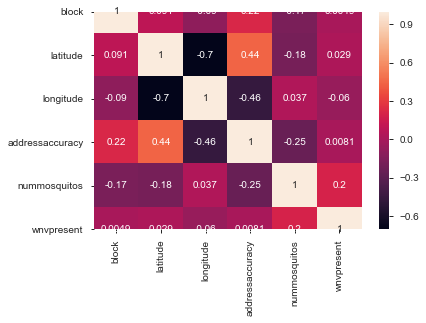

In [10]:
# plot the heatmap and annotation on it
sns.heatmap(train.corr(), annot=True)
#most important factor for wnvpresent is number of mosquitos

In [11]:
train.describe()

,block,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


In [12]:
test.describe()

,id,block,latitude,longitude,addressaccuracy
count,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000
mean,58147.000000,41.131100,41.849389,-87.693658,7.954357
std,33571.041765,24.864726,0.106593,0.080699,1.252733
min,1.000000,10.000000,41.644612,-87.930995,3.000000
25%,29074.000000,18.000000,41.753411,-87.750938,8.000000
50%,58147.000000,39.000000,41.862292,-87.694991,8.000000
75%,87220.000000,61.000000,41.951866,-87.648860,9.000000
max,116293.000000,98.000000,42.017430,-87.531635,9.000000


In [13]:
spray.describe()

,latitude,longitude
count,14835.000000,14835.000000
mean,41.904828,-87.736690
std,0.104381,0.067292
min,41.713925,-88.096468
25%,41.785001,-87.794225
50%,41.940075,-87.727853
75%,41.980978,-87.694108
max,42.395983,-87.586727


###### Traps distribution

In [14]:
area=((train.longitude.min(),train.longitude.max(), train.latitude.min(), train.latitude.max()))
area

(-87.930995, -87.531635, 41.644612, 42.01743)

In [15]:
Chicagomap = plt.imread('../map/research_area.png')

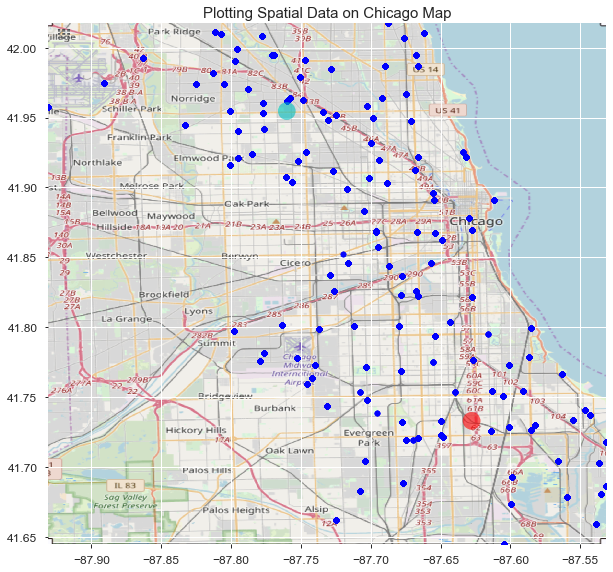

In [16]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(train.longitude, train.latitude, zorder=1,alpha= 0.8, c='b', s=30)
ax.set_title('Plotting Spatial Data on Chicago Map',fontsize=15)
ax.set_xlim(area[0],area[1])
ax.set_ylim(area[2],area[3])
ax.imshow(Chicagomap, zorder=0, extent = area, aspect= 'equal')
plt.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
area = 300
colors = ['c','r']
plt.scatter([-87.760070, -87.627796], [41.954690,41.732984], s=area, c = colors, marker='o', alpha=.6)

###### NumMosquitos and wnvpresent understanding

In [17]:
area=((train.longitude.min(),train.longitude.max(), train.latitude.min(), train.latitude.max()))
area

(-87.930995, -87.531635, 41.644612, 42.01743)

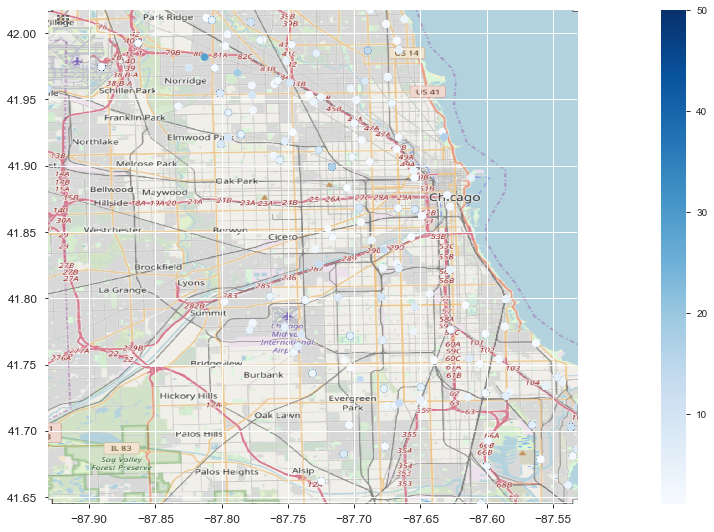

In [18]:
fig, ax = plt.subplots(figsize = (30,20))
plt.subplot(211)
plt.scatter(train.longitude, train.latitude, c=train.nummosquitos,cmap='Blues')#plt.cm.get_cmap('Blues', 10))
plt.colorbar()
plt.imshow(Chicagomap, zorder=0, extent = area, aspect= 'equal')
plt.tick_params(labelsize=12)
plt.show()

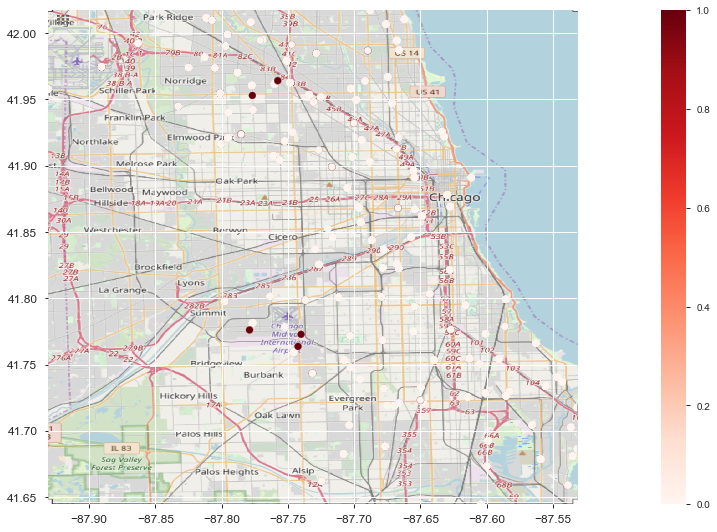

In [19]:
fig, ax = plt.subplots(figsize = (30,20))
plt.subplot(211)
plt.scatter(train.longitude, train.latitude, c=train.wnvpresent,cmap='Reds')#plt.cm.get_cmap('Blues', 10))
plt.colorbar()
plt.imshow(Chicagomap, zorder=0, extent = area, aspect= 'equal')
plt.tick_params(labelsize=12)
plt.show()

###### training data cleanse

In [20]:
train['date'] = pd.to_datetime(train.date)
test.date=pd.to_datetime(test.date)
spray.date=pd.to_datetime(spray.date)

In [21]:
# Functions to extract month and day from dataset
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day

In [22]:
label=train.wnvpresent

In [23]:
# drop address columns
train = train.drop(['address', 'addressnumberandstreet','nummosquitos'], axis = 1)
test = test.drop(['id', 'address', 'addressnumberandstreet'], axis = 1)

In [24]:
# Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['species'].values) + list(test['species'].values))
train['species'] = lbl.transform(train['species'].values)
test['species'] = lbl.transform(test['species'].values)

lbl.fit(list(train['street'].values) + list(test['street'].values))
train['street'] = lbl.transform(train['street'].values)
test['street'] = lbl.transform(test['street'].values)

lbl.fit(list(train['trap'].values) + list(test['trap'].values))
train['trap'] = lbl.transform(train['trap'].values)
test['trap'] = lbl.transform(test['trap'].values)

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
date               116293 non-null datetime64[ns]
species            116293 non-null int64
block              116293 non-null int64
street             116293 non-null int64
trap               116293 non-null int64
latitude           116293 non-null float64
longitude          116293 non-null float64
addressaccuracy    116293 non-null int64
year               116293 non-null int64
month              116293 non-null int64
day                116293 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(8)
memory usage: 9.8 MB


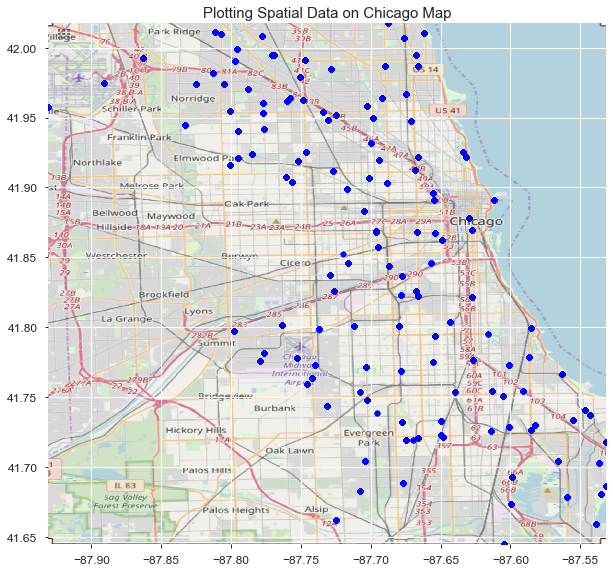

In [26]:
area=((train.longitude.min(),train.longitude.max(), train.latitude.min(), train.latitude.max()))
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(train.longitude, train.latitude, zorder=1,alpha= 0.8, c='b', s=30)
ax.set_title('Plotting Spatial Data on Chicago Map',fontsize=15)
ax.set_xlim(area[0],area[1])
ax.set_ylim(area[2],area[3])
ax.imshow(Chicagomap, zorder=0, extent = area, aspect= 'equal')
plt.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [27]:
train.to_csv('../train_test_weather/train_cleaned.csv',encoding='utf-8')

In [28]:
test.to_csv('../train_test_weather/test_cleaned.csv',encoding='utf-8')

#### 2. spray data EDA

In [29]:
min_spray = spray.groupby('date').min()
max_spary = spray.groupby('date').max()

In [30]:
spray.shape

(14835, 4)

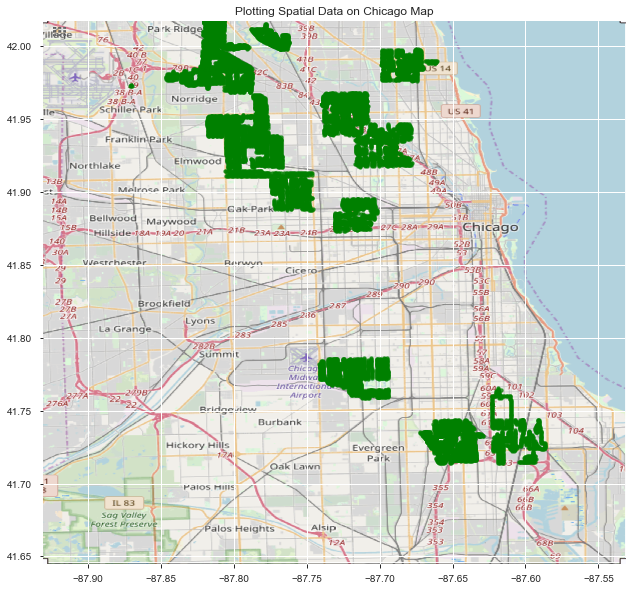

In [31]:
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(spray.longitude, spray.latitude, zorder=1, alpha= 0.8, c='g', s=15)
ax.set_title('Plotting Spatial Data on Chicago Map')
ax.set_xlim(area[0],area[1])
ax.set_ylim(area[2],area[3])
ax.imshow(Chicagomap, zorder=0, extent = area, aspect= 'equal')

#### 3. weather data cleaning and EDA

In [32]:
weather = pd.read_csv('../assets/weather.csv')
weather.columns=map(str.lower,weather.columns)
weather.date=pd.to_datetime(weather.date)

In [33]:
#profile_weather= weather.profile_report(title='Pandas Profiling Report', plot={'histogram': {'bins': 8}})
#profile_weather.to_file(output_file="output_weather.html")

In [34]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
station        2944 non-null int64
date           2944 non-null datetime64[ns]
tmax           2944 non-null int64
tmin           2944 non-null int64
tavg           2944 non-null object
depart         2944 non-null object
dewpoint       2944 non-null int64
wetbulb        2944 non-null object
heat           2944 non-null object
cool           2944 non-null object
sunrise        2944 non-null object
sunset         2944 non-null object
codesum        2944 non-null object
depth          2944 non-null object
water1         2944 non-null object
snowfall       2944 non-null object
preciptotal    2944 non-null object
stnpressure    2944 non-null object
sealevel       2944 non-null object
resultspeed    2944 non-null float64
resultdir      2944 non-null int64
avgspeed       2944 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(15)
memory usage: 506.1+ KB


In [35]:
for col in weather.columns:
    print(col,',',np.dtype(weather[col]),':',weather[col].unique(),'Count',':',weather[col].nunique())

station , int64 : [1 2] Count : 2
date , datetime64[ns] : ['2007-05-01T00:00:00.000000000' '2007-05-02T00:00:00.000000000'
 '2007-05-03T00:00:00.000000000' ... '2014-10-29T00:00:00.000000000'
 '2014-10-30T00:00:00.000000000' '2014-10-31T00:00:00.000000000'] Count : 1472
tmax , int64 : [ 83  84  59  60  66  67  78  68  82  80  77  76  70  73  64  65  69  90
  62  61  71  79  87  89  88  75  85  86  81  72  63  91  92  93  74  94
  54  53  56  57  58  55  50  95  52  47  45  51  48  44  49  46  96  99
 100 101  97  98 102 103 104  42  41] Count : 63
tmin , int64 : [50 52 42 43 46 48 49 51 53 54 47 60 61 63 56 59 44 57 45 55 66 65 70 68
 62 67 64 58 71 69 73 75 72 74 39 41 40 37 34 38 35 36 33 31 32 76 77 29
 78 79 80 81 82 83] Count : 54
tavg , object : ['67' '68' '51' '52' '56' '58' 'M' '60' '59' '65' '70' '69' '71' '61' '55'
 '57' '73' '72' '53' '62' '63' '74' '75' '78' '76' '77' '66' '80' '64'
 '81' '82' '79' '85' '84' '83' '50' '49' '46' '48' '45' '54' '47' '44'
 '40' '41' '38' '39' 

the result of profil_report for weather: there are many M value, T values..

In [36]:
# replace some missing values and T with -1
weather = weather.replace('M', np.nan)
weather = weather.replace('-', np.nan)
weather = weather.replace('T', np.nan)
weather = weather.replace(' T', np.nan)
weather = weather.replace('  T', np.nan)

In [37]:
#drop not meaningful columns
weather.drop(['snowfall','codesum','water1','depart','depth'],axis=1,inplace=True)

In [38]:
'''non_numeric = []
for col in weather:
    if weather[col].dtypes != "float64" or weather[col].dtypes !='int64':
        non_numeric.append(col)'''

'non_numeric = []\nfor col in weather:\n    if weather[col].dtypes != "float64" or weather[col].dtypes !=\'int64\':\n        non_numeric.append(col)'

In [39]:
# convert columns to numeric
weather['tavg'] = pd.to_numeric(weather.tavg)
weather['wetbulb'] = pd.to_numeric(weather.wetbulb)
weather['heat'] = pd.to_numeric(weather.heat)
weather['cool'] = pd.to_numeric(weather.cool)
weather['preciptotal'] = pd.to_numeric(weather.preciptotal)
weather['stnpressure'] = pd.to_numeric(weather.stnpressure)
weather['sealevel'] = pd.to_numeric(weather.sealevel)
weather['avgspeed'] = pd.to_numeric(weather.avgspeed)

convert sunrise and sunset to time 

In [40]:
weather.sunrise=pd.to_datetime(weather.sunrise,format='%H%M').dt.time

In [41]:
weather['sunset'] = weather['sunset'].astype(str)

In [42]:
for i in range(len(weather['sunset'])):
    if weather['sunset'][i][2:]== '60':
        weather['sunset'][i]= int(weather['sunset'][i][:2])+1
        weather['sunset'][i]=str( weather['sunset'][i])+'00'

/Users/fionna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/fionna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [43]:
from dateutil.parser import parse

for i in range(len(weather['sunset'])):
    if weather['sunset'][i]!='nan':
        dt=weather['sunset'][i][:2]+':'+weather['sunset'][i][2:]
        dt = parse(dt)
        weather['sunset'][i]=dt.time()

/Users/fionna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


clean null value

In [44]:
weather.isnull().sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
dewpoint          0
wetbulb           4
heat             11
cool             11
sunrise        1472
sunset            0
preciptotal     320
stnpressure       4
sealevel          9
resultspeed       0
resultdir         0
avgspeed          3
dtype: int64

In [45]:
for i in range(1,len(weather.index)):
    if str(weather['preciptotal'][i])=='nan':
        weather['preciptotal'][i]= weather['preciptotal'][i-1]
#weather['preciptotal_1'] = weather['preciptotal'].shift(1)

/Users/fionna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
for i in range(len(weather.index)):
    if str(weather['tavg'][i])=='nan':
        weather['tavg'][i]= (weather.tmin[i] + weather.tmax[i]) / 2

/Users/fionna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
weather.wetbulb.fillna(weather.wetbulb.mean(),inplace=True)

In [48]:
weather.heat.fillna(weather.heat.mean(),inplace=True)

In [49]:
weather.cool.fillna(weather.cool.mean(),inplace=True)

In [50]:
weather.avgspeed.fillna(weather.avgspeed.mean(),inplace=True)

In [51]:
weather.stnpressure.fillna(weather.stnpressure.mean(),inplace=True)

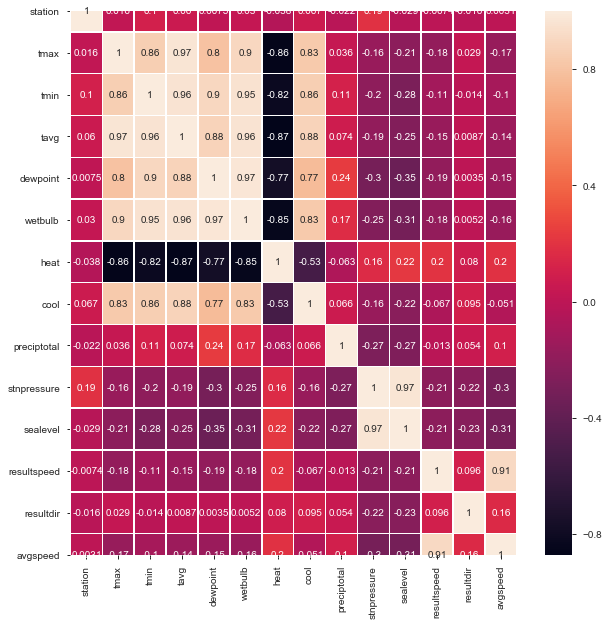

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(weather.corr(), annot=True,linewidths=0.5)

In [53]:
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['station']==1]
weather_stn2 = weather[weather['station']==2]
weather_stn1 = weather_stn1.drop('station', axis=1)
weather_stn2 = weather_stn2.drop('station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='date')

In [54]:
weather.isnull().sum()

date                0
tmax_x              0
tmin_x              0
tavg_x              0
dewpoint_x          0
wetbulb_x           0
heat_x              0
cool_x              0
sunrise_x           0
sunset_x            0
preciptotal_x       0
stnpressure_x       0
sealevel_x          5
resultspeed_x       0
resultdir_x         0
avgspeed_x          0
tmax_y              0
tmin_y              0
tavg_y              0
dewpoint_y          0
wetbulb_y           0
heat_y              0
cool_y              0
sunrise_y        1472
sunset_y            0
preciptotal_y       0
stnpressure_y       0
sealevel_y          4
resultspeed_y       0
resultdir_y         0
avgspeed_y          0
dtype: int64

In [55]:
weather.sunrise_y=weather.sunrise_x

In [56]:
#weather['humidity'] = (weather.dewpoint_x)/(weather.tavg_x.apply(float))

In [57]:
# Taking derivities of some columns
#weather['dewpoint_diff'] = weather.dewpoint_x.diff()
#weather['precip_diff'] = weather.preciptotal_x.apply(float).diff()
#weather['tavg_diff'] = weather.tavg_x.apply(float).diff()

In [58]:
weather.to_csv('../train_test_weather/weather_cleaned.csv',encoding='utf-8')

#### 3. merge training and weather dataframe

In [59]:
train['date'].dt.year.unique()

array([2007, 2009, 2011, 2013])

In [60]:
test['date'].dt.year.unique()

array([2008, 2010, 2012, 2014])

In [61]:
weather['date'].dt.year.unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [62]:
train.columns

Index(['date', 'species', 'block', 'street', 'trap', 'latitude', 'longitude',
       'addressaccuracy', 'wnvpresent', 'year', 'month', 'day'],
      dtype='object')

In [63]:
test.columns

Index(['date', 'species', 'block', 'street', 'trap', 'latitude', 'longitude',
       'addressaccuracy', 'year', 'month', 'day'],
      dtype='object')

In [64]:
weather.shape

(1472, 31)

In [65]:
train_w = train.merge(weather, on='date')
test_w = test.merge(weather, on='date')

In [66]:
train_w.shape

(10506, 42)

In [67]:
test_w.shape

(116293, 41)

In [68]:
train_w.to_csv('../train_test_weather/train_merged.csv',encoding='utf-8')
test_w.to_csv(,encoding='utf-8')

NameError: name 'test_w' is not defined